# Monk - Neural Network
In this notebook we apply NNs to solve the Monk 1, Monk 2 and Monk 3 benchmarks

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [15]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [16]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [17]:
# Define our classifier:

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1):
        super(MonkClassifier, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [18]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=5000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    # to implement minibatch:
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    min_loss = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train) #computes MSE
        # Calculate accuracy
        predicted_labels = torch.round(y_pred)
        correct_predictions = (predicted_labels == y_train).sum().item()
        total_samples = y_train.size(0)
        accuracy = correct_predictions / total_samples

        train_losses.append(train_loss.item())
        train_accuracies.append(accuracy)
        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'Accuracy: {accuracy:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} Accuracy: {test_accuracy:.4f} ', end='\r')

        # Check for convergence
        if train_loss.item() < min_loss and abs(train_loss.item()-min_loss)>1e-4:
            patience_counter = 0
            min_loss = train_loss.item()
        else:
            patience_counter += 1

        if patience_counter == patience:
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), accuracy, test_accuracy

In [19]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=5000,
                                         plot_curves=False, N = 3):
    '''
    Train the model N times, each time with a different random weight initialization,
    to estimate the model performances with mean and variance

    Parameters:
    - x_train (array-like): Training data features.
    - y_train (array-like): Training data labels.
    - x_test (array-like): Test/Validation data features.
    - y_test (array-like): Test/Validation data labels.
    - hidden_size (int): Size of the hidden layer in the neural network.
    - learning_rate (float): Learning rate for training.
    - momentum (float): Momentum factor in optimization.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient.
    - num_epochs (int, optional): Number of epochs for training. Default is 5000.
    - plot_curves (bool, optional): If True, plot learning curves. Default is False.
    - N (int, optional): Number of times the model is trained with new initializations. Default is 3.

    Returns:
    A tuple containing:
    - The last trained model (object).
    - Mean training loss (float).
    - Mean testing loss (float).
    - Mean training accuracy (float).
    - Mean testing accuracy (float).

    '''

    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves,
                        num_epochs=num_epochs)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')
    return _, np.mean(train_losses), np.mean(test_losses), np.mean(train_accs), np.mean(test_accs)

In [20]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False, num_epochs=5000):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    This function iterates over all combinations of provided hyperparameters and evaluates
    the model's performance using k-fold cross-validation. For each combination of hyperparameters,
    it trains the model on each fold and computes the average training and validation losses and
    accuracies. The combination with the highest average validation accuracy is considered the best.

    Parameters:
    - hidden_sizes (list): List of integers representing the sizes of the hidden layer to explore.
    - learning_rates (list): List of floats representing the learning rates to explore.
    - momentums (list): List of floats representing the momentum values to explore.
    - batch_sizes (list): List of integers representing the batch sizes to explore.
    - reg_coeffs (list): List of floats representing the regularization coefficients to explore.
    - k_folds (int): Number of folds to use in cross-validation.
    - x (torch.Tensor): The input data.
    - y (torch.Tensor): The target labels.
    - plot_curves (bool, optional): If True, plots training curves for each hyperparameter combination.
    - num_epochs (int, optional): Number of epochs to train the model for each fold and hyperparameter set.

    Returns:
    - best_hyperparams (list): A list containing the best combination of hyperparameters
      [hidden_size, learning_rate, momentum, batch_size, reg_coeff] based on the highest
      average validation accuracy achieved during cross-validation.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each fold
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = train_with_different_initializations(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

# Monk 1

In [21]:
#Load and preprocess the data
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation
For the Monk1 we explored different hyperparameters by hand. We easily found a combination leading to a 100% accuracy.

In [22]:
hidden_sizes = [5]
learning_rates = [0.01]
momentums = [0.9]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.9; batch size = 4; lambda = 0


Training - Epoch [378/5000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [378/5000], Loss: 0.0405 Accuracy: 0.9600 
 N. Epochs = 378 - Loss (train | test)= (0.0008559 | 0.04045) - Accuracy (train | test) = (1.0 | 0.96)
Training - Epoch [326/5000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [326/5000], Loss: 0.0064 Accuracy: 1.0000 
 N. Epochs = 326 - Loss (train | test)= (0.0009461 | 0.006409) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [485/5000], Loss: 0.0013, Accuracy: 1.0000 | Test - Epoch [485/5000], Loss: 0.0973 Accuracy: 0.8800 
 N. Epochs = 485 - Loss (train | test)= (0.001267 | 0.09727) - Accuracy (train | test) = (1.0 | 0.88)
Train Loss: 0.001023 +- 0.0001762
Test Loss: 0.04804 +- 0.03748
Train Acc: 100.0 +- 0.0 %
Test Acc: 94.67 +- 4.989 %
Training - Epoch [325/5000], Loss: 0.0007, Accuracy: 1.0000 | Test - Epoch [325/5000], Loss: 0.0012 Accuracy: 1.0000 
 N. Epochs = 325 - Loss (train | test)= (0.0006539 | 0.001219) - Accuracy (train | test) = (1.0 | 1.0)


## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [23]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

Training - Epoch [326/5000], Loss: 0.0008, Accuracy: 1.0000 | Test - Epoch [326/5000], Loss: 0.0011 Accuracy: 1.0000 
 N. Epochs = 326 - Loss (train | test)= (0.0008459 | 0.001104) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [352/5000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [352/5000], Loss: 0.0040 Accuracy: 1.0000 
 N. Epochs = 352 - Loss (train | test)= (0.001091 | 0.004049) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [384/5000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [384/5000], Loss: 0.0020 Accuracy: 1.0000 
 N. Epochs = 384 - Loss (train | test)= (0.00107 | 0.002043) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [330/5000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [330/5000], Loss: 0.0058 Accuracy: 0.9954 
 N. Epochs = 330 - Loss (train | test)= (0.0008713 | 0.005811) - Accuracy (train | test) = (1.0 | 0.9953703703703703)
Training - Epoch [320/5000], Loss: 0.0008, Accuracy: 1.0000 | Test - Epoch [320/5000], Loss: 0.0024 Accu

(320, 0.0009308496490120887, 0.003078043833374977, 1.0, 0.999074074074074)

# Retrain the model to make final plots

Training - Epoch [339/5000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [339/5000], Loss: 0.0019 Accuracy: 1.0000 
 N. Epochs = 339 - Loss (train | test)= (0.0009749 | 0.001874) - Accuracy (train | test) = (1.0 | 1.0)


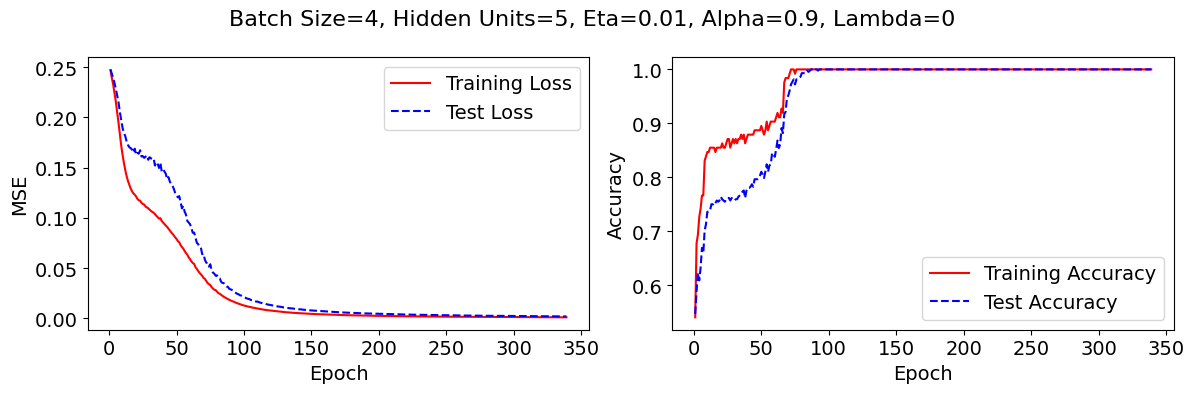

(339, 0.000974909053184092, 0.0018737628124654293, 1.0, 1.0)

In [24]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [25]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

As with the Monk1 we explored different hyperparameters by hand, and we easily found a combination leading to a 100% accuracy.

In [26]:
hidden_sizes = [4]
learning_rates = [0.05]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=4; lr=0.05; alpha = 0.8; batch size = 4; lambda = 0
Training - Epoch [176/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [176/5000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 176 - Loss (train | test)= (0.0004778 | 0.0006043) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [141/5000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [141/5000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 141 - Loss (train | test)= (0.0003376 | 0.0004364) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [227/5000], Loss: 0.0525, Accuracy: 0.9481 | Test - Epoch [227/5000], Loss: 0.2560 Accuracy: 0.7353 
 N. Epochs = 227 - Loss (train | test)= (0.05251 | 0.256) - Accuracy (train | test) = (0.9481481481481482 | 0.7352941176470589)
Train Loss: 0.01778 +- 0.02456
Test Loss: 0.08569 +- 0.1205
Train Acc: 98.27 +- 2.444 %
Test Acc: 91.18 +- 12.48 %
Training - Epoch [156/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [156/5000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 

In [27]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

Training - Epoch [188/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [188/5000], Loss: 0.0009 Accuracy: 1.0000 
 N. Epochs = 188 - Loss (train | test)= (0.0004733 | 0.0008823) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [177/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [177/5000], Loss: 0.0007 Accuracy: 1.0000 
 N. Epochs = 177 - Loss (train | test)= (0.000507 | 0.0006657) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [163/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [163/5000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 163 - Loss (train | test)= (0.0004913 | 0.0005721) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [128/5000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [128/5000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 128 - Loss (train | test)= (0.0002843 | 0.0003023) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [182/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [182/5000], Loss: 0.0005 Accuracy: 1.0

(182, 0.0004450125619769096, 0.0005843459162861109, 1.0, 1.0)

Training - Epoch [161/5000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [161/5000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 161 - Loss (train | test)= (0.0003631 | 0.000557) - Accuracy (train | test) = (1.0 | 1.0)


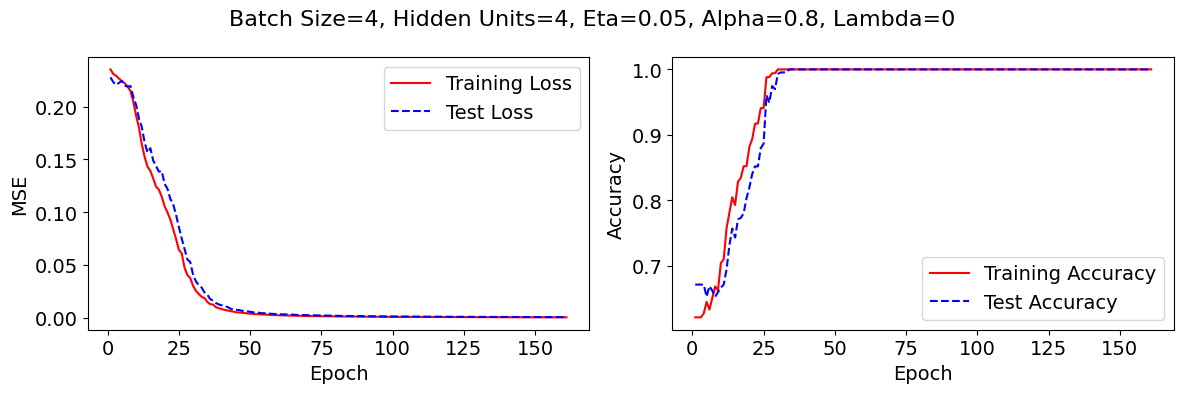

(161, 0.0003630604478530586, 0.0005570293869823217, 1.0, 1.0)

In [28]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [29]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

We perform some grid searches to find optimal hyperparameters. First we do not implement regularization.

In [31]:
'''
hidden_sizes = [5]
learning_rates = [0.1,0.01,0.001]
momentums = [0.7,0.8,0.9]
batch_sizes = [16]
reg_coeffs = [0]
# Best [5, 0.001, 0.9, 16, 0]
'''

'''
hidden_sizes = [5]
learning_rates = [0.001,0.002,0.003]
momentums = [0.7,0.8,0.9]
batch_sizes = [16]
reg_coeffs = [0]
'''

hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0


KeyboardInterrupt: 

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=2000)

# Monk 3 (with regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

We now keep the same hyperparameters as before, and we introduce the regularization. In order to find the best value of lambda, we perform a small grid search.

In [ ]:
'''
hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [1e-2,1e-3,1e-4]
'''

hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [1e-2]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False,
                                    num_epochs=2000)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0.01
Training - Epoch [376/2000], Loss: 0.0746, Accuracy: 0.9175 | Test - Epoch [376/2000], Loss: 0.0466 Accuracy: 1.0000 
 N. Epochs = 376 - Loss (train | test)= (0.07464 | 0.04661) - Accuracy (train | test) = (0.9175257731958762 | 1.0)
Training - Epoch [558/2000], Loss: 0.0741, Accuracy: 0.9278 | Test - Epoch [558/2000], Loss: 0.0523 Accuracy: 1.0000 
 N. Epochs = 558 - Loss (train | test)= (0.07414 | 0.05235) - Accuracy (train | test) = (0.9278350515463918 | 1.0)
Training - Epoch [428/2000], Loss: 0.0766, Accuracy: 0.9278 | Test - Epoch [428/2000], Loss: 0.0467 Accuracy: 1.0000 
 N. Epochs = 428 - Loss (train | test)= (0.07659 | 0.04674) - Accuracy (train | test) = (0.9278350515463918 | 1.0)
Train Loss: 0.07512 +- 0.001057
Test Loss: 0.04856 +- 0.002677
Train Acc: 92.44 +- 0.486 %
Test Acc: 100.0 +- 0.0 %
Training - Epoch [608/2000], Loss: 0.0559, Accuracy: 0.9485 | Test - Epoch [608/2000], Loss: 0.1074 Accuracy: 0.8800

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               num_epochs=5000,
               N=5)

Training - Epoch [565/5000], Loss: 0.0759, Accuracy: 0.9344 | Test - Epoch [565/5000], Loss: 0.0580 Accuracy: 0.9722 
 N. Epochs = 565 - Loss (train | test)= (0.07588 | 0.05802) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [471/5000], Loss: 0.0662, Accuracy: 0.9344 | Test - Epoch [471/5000], Loss: 0.0507 Accuracy: 0.9722 
 N. Epochs = 471 - Loss (train | test)= (0.06624 | 0.05071) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [445/5000], Loss: 0.0654, Accuracy: 0.9344 | Test - Epoch [445/5000], Loss: 0.0504 Accuracy: 0.9722 
 N. Epochs = 445 - Loss (train | test)= (0.06538 | 0.05043) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [449/5000], Loss: 0.0644, Accuracy: 0.9344 | Test - Epoch [449/5000], Loss: 0.0495 Accuracy: 0.9722 
 N. Epochs = 449 - Loss (train | test)= (0.06442 | 0.04953) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training

(518,
 0.06725055277347565,
 0.05164465010166168,
 0.9344262295081969,
 0.9722222222222221)

Training - Epoch [471/5000], Loss: 0.0643, Accuracy: 0.9344 | Test - Epoch [471/5000], Loss: 0.0495 Accuracy: 0.9722 
 N. Epochs = 471 - Loss (train | test)= (0.06425 | 0.04948) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)


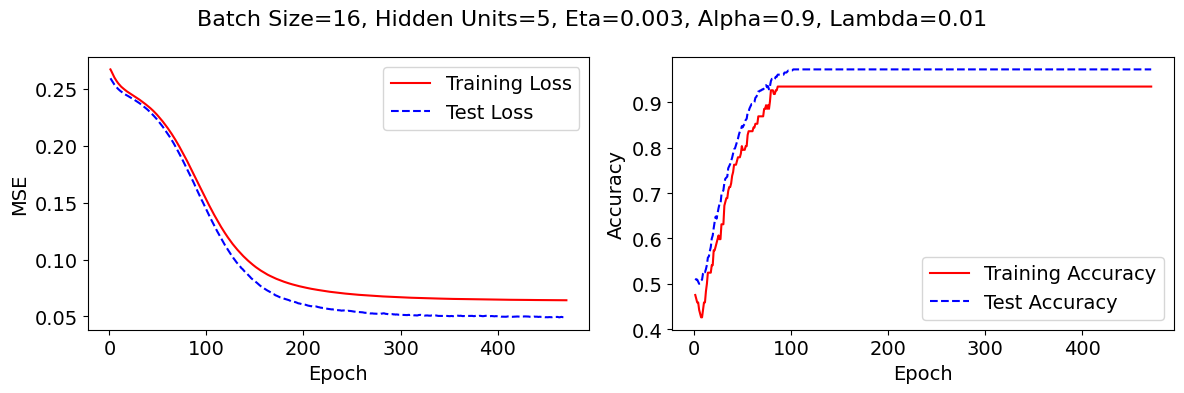

(471,
 0.06425153464078903,
 0.04948419705033302,
 0.9344262295081968,
 0.9722222222222222)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=5000)